In [1]:
!pip install pandas numpy matplotlib joblib scikit-learn xgboost imbalanced-learn

# 📦 Importing Necessary Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter

# 📂 Loading Dataset

In [3]:
# Load the dataset
df = pd.read_csv("/content/personality_dataset.csv")

# Check the df shape

In [4]:
# Initial inspection
initial_shape = df.shape
initial_shape

(2900, 8)

# Check whether dataset is balanced or not

In [5]:
df['Personality'].value_counts()

,count
Personality,
Extrovert,1491
Introvert,1409


Both categories appear to have nearly equal representation, so the dataset can be considered balanced.

# Removing Duplicate Records

In [6]:
# Count of total duplicate rows
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

Number of duplicate rows: 388


In [7]:
# Step 1: Drop exact duplicates
df.drop_duplicates(inplace=True)

# Step 2: Reset index (optional)
df.reset_index(drop=True, inplace=True)

In [8]:
df

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,No,4.0,6.0,No,13.0,5.0,Extrovert
1,9.0,Yes,0.0,0.0,Yes,0.0,3.0,Introvert
2,9.0,Yes,1.0,2.0,Yes,5.0,2.0,Introvert
3,0.0,No,6.0,7.0,No,14.0,8.0,Extrovert
4,3.0,No,9.0,4.0,No,8.0,5.0,Extrovert
...,...,...,...,...,...,...,...,...
2507,0.0,No,9.0,3.0,No,12.0,NaN,Extrovert
2508,3.0,No,8.0,3.0,No,14.0,9.0,Extrovert
2509,4.0,Yes,1.0,1.0,Yes,4.0,0.0,Introvert
2510,11.0,Yes,1.0,NaN,Yes,2.0,0.0,Introvert


# Check the df shape after removed the duplicate records

In [9]:
# Initial inspection
shape_after_removing_duplicates = df.shape
shape_after_removing_duplicates

(2512, 8)

# Encoding Categorical Variables

In [10]:
# Encode binary categorical columns
binary_cols = ['Stage_fear', 'Drained_after_socializing']
df[binary_cols] = df[binary_cols].apply(lambda x: x.map({'Yes': 1, 'No': 0}))

In [11]:
# Encode the target label
df['Personality'] = df['Personality'].map({'Introvert': 0, 'Extrovert': 1})

In [12]:
df[:5]

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,4.0,0.0,4.0,6.0,0.0,13.0,5.0,1
1,9.0,1.0,0.0,0.0,1.0,0.0,3.0,0
2,9.0,1.0,1.0,2.0,1.0,5.0,2.0,0
3,0.0,0.0,6.0,7.0,0.0,14.0,8.0,1
4,3.0,0.0,9.0,4.0,0.0,8.0,5.0,1


# Handling missing values

In [13]:
missing_values = df.isnull().sum()
missing_values

,0
Time_spent_Alone,61
Stage_fear,73
Social_event_attendance,61
Going_outside,65
Drained_after_socializing,51
Friends_circle_size,75
Post_frequency,63
Personality,0


In [14]:
num_cols = df.drop(columns=['Personality']).select_dtypes(include=[np.number]).columns
cat_cols = binary_cols

In [15]:
# Impute numeric with median, categorical with mode
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0]).astype(int)

In [16]:
missing_values = df.isnull().sum()
missing_values

,0
Time_spent_Alone,0
Stage_fear,0
Social_event_attendance,0
Going_outside,0
Drained_after_socializing,0
Friends_circle_size,0
Post_frequency,0
Personality,0


After handle the missing values, there are no NAN values in the Dataset.

# Check whether the dataset is balanced after removing duplicate rows.

In [17]:
df['Personality'].value_counts()

,count
Personality,
1,1417
0,1095


- After removing duplicate rows, the dataset shows a slight imbalance:
- 1,417 samples labeled as Personality = 1 and 1,095 as Personality = 0.
- While not drastically skewed, this difference could still impact model performance.
- Consider applying balancing techniques like SMOTE.

# Splitting data into train and Test Sets

In [18]:
# Feature and target split
X = df.drop(columns='Personality')
y = df['Personality']

In [19]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [20]:
print("Before SMOTE:", Counter(y_train))  # y_train is your training label

Before SMOTE: Counter({1: 1133, 0: 876})


# Handling Calss Imbalance with SMOTE

In [21]:
# Apply SMOTE only to training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

In [22]:
# Check new class distribution
print("After SMOTE:", Counter(y_train_resampled))

After SMOTE: Counter({1: 1133, 0: 1133})


# Hyperparameter Tuning using GridSearchCV

In [23]:
# Define models and hyperparameter grids
models = {
    'LogisticRegression': {
        'model': LogisticRegression(max_iter=1000),
        'params': {
            'C': [0.1, 1.0, 10],
            'solver': ['lbfgs', 'liblinear']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [5, 10, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(eval_metric='logloss'),
        'params': {
            'n_estimators': [50, 100],
            'max_depth': [3, 5],
            'learning_rate': [0.1, 0.3],
            'subsample': [0.8, 1.0]
        }
    },
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion': ['gini', 'entropy'],
            'max_depth': [3, 5, 10, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
    }
}

In [24]:
# Run grid search for each model
best_models = {}
for name, mp in models.items():
    print(f"Running GridSearchCV for {name}...")
    clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring='accuracy', n_jobs=-1)
    clf.fit(X_train_resampled, y_train_resampled)
    best_models[name] = clf
    print(f"{name} best score: {clf.best_score_:.4f}")
    print(f"{name} best params: {clf.best_params_}\n")


Running GridSearchCV for LogisticRegression...
LogisticRegression best score: 0.9290
LogisticRegression best params: {'C': 0.1, 'solver': 'lbfgs'}

Running GridSearchCV for RandomForest...
RandomForest best score: 0.9320
RandomForest best params: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}

Running GridSearchCV for XGBoost...
XGBoost best score: 0.9307
XGBoost best params: {'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 50, 'subsample': 1.0}

Running GridSearchCV for DecisionTree...
DecisionTree best score: 0.9294
DecisionTree best params: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}



* After removing duplicate records to improve dataset quality, the cross-validated accuracy dropped slightly from 93.7% to 92.98%, indicating that earlier performance was mildly inflated due to data redundancy. This cleaning step enhances model generalizability and reliability. But there aws class imbalance due to duplication row removal, so use SMOTE technique to balance the data, now RandomForect shows better accuracy than other models.


In [25]:
final_model = best_models["RandomForest"].best_estimator_
final_model

RandomForestClassifier(min_samples_leaf=2, min_samples_split=5)

# Evaluating Model Performance

In [26]:
# Evaluate on test data
y_pred = final_model.predict(X_test)
report = classification_report(y_test, y_pred, target_names=['Introvert', 'Extrovert'], output_dict=True)
conf_matrix = confusion_matrix(y_test, y_pred)

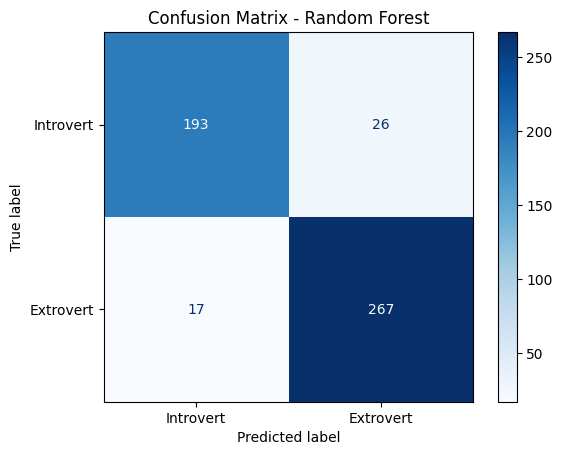

In [27]:
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Introvert', 'Extrovert'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Random Forest")
plt.show()

# Evaluate the importance of each feature in contributing to the model's predictions

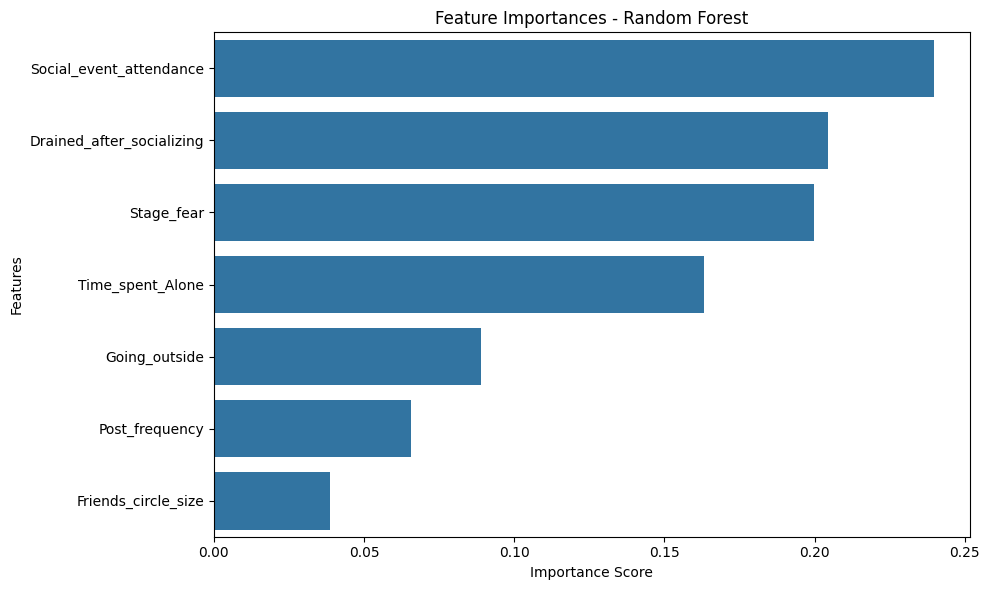

In [28]:
# Plot feature importances
feature_importances = pd.Series(final_model.feature_importances_, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importances.values, y=feature_importances.index)
plt.title("Feature Importances - Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

- Visualize how each feature contributes to the model's prediction.
- 'Social_event_attendance' has the highest impact, followed by 'Time_spent_Alone' and 'Drained_after_socializing'.
- Features like 'Friends_circle_size' contribute the least, indicating they may have less predictive power.


# Save the model

In [29]:
joblib.dump(final_model, 'personality_model.pkl')

['personality_model.pkl']